### Preprocessing and Modelling

#### Importing Necessary Libraries

In [1]:
# For data manipulation 
import pandas as pd
# For data analysis
import numpy as np
#For data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Warning libraries
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

# Modelling libraries
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm #a library to help with auto_arima
import itertools

# Metrics Libraries
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
#Loading the cleaned data

new_data = pd.read_csv('new_df.csv')

In [3]:
new_data.head()

,Date,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,22yr_ROI,22yr_CV,5yr_ROI,5yr_CV,value
0,1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,2.083782,0.256487,0.260827,0.066302,334200.0
1,1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,0.365295,0.152680,0.533842,0.124597,235700.0
2,1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,0.567966,0.143950,0.283158,0.072385,210400.0
3,1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1.623971,0.237364,0.258788,0.056243,498100.0
4,1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,0.571798,0.178326,0.070485,0.023086,77300.0


In [4]:
new_data['Date'] = pd.to_datetime(new_data.Date)
new_data.set_index('Date',inplace = True)

#### Preprocessing

In this phase we will transform the raw data into a form that will make it suitable for building and training our model.

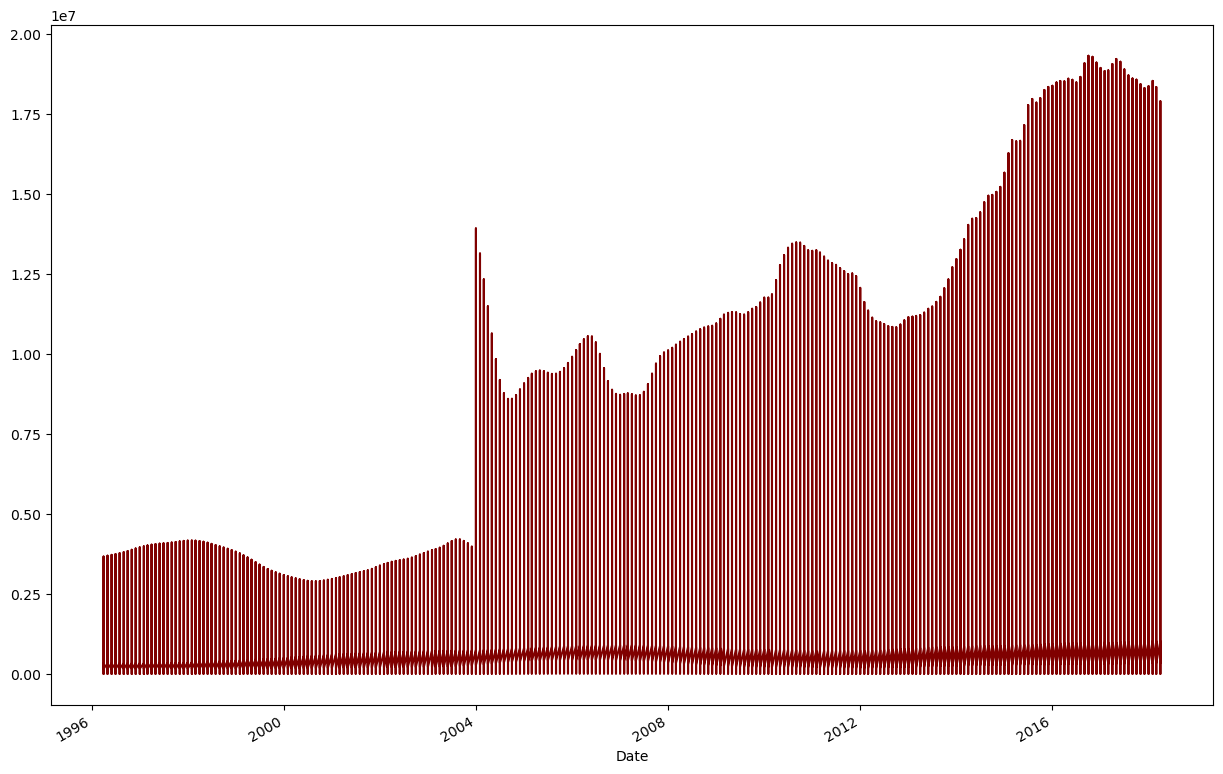

In [5]:
# Visualizing our data

new_data.value.plot(figsize=(15,10),color = 'maroon');

From the graph, there seems to be an increasing trend in data. However,let's reconfirm this using both rolling statistics and the Dickey-Fuller test.

#### Stationarity Test

In [6]:
# create a stationarity function 
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=6, center=False).mean()
    roll_std = TS.rolling(window=6, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

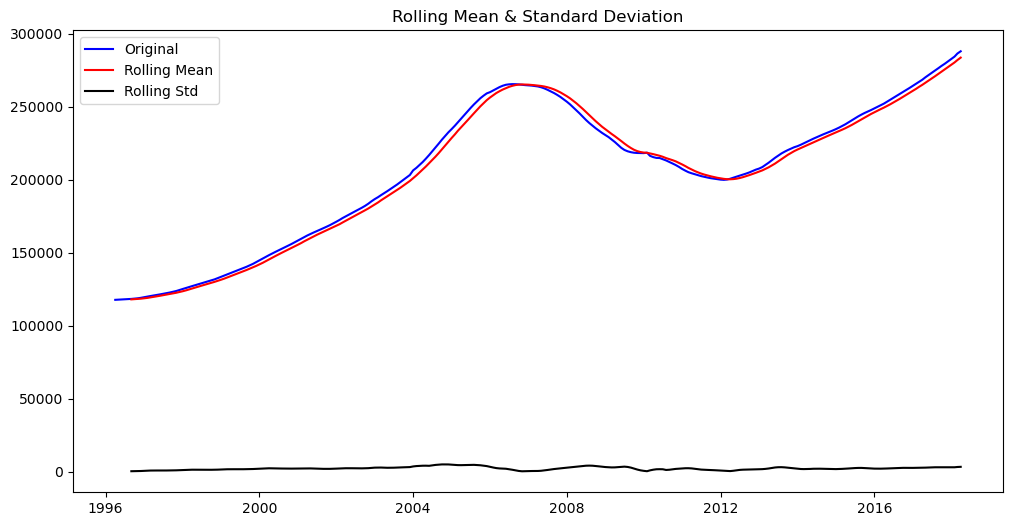

Results of Dickey-Fuller Test: 

Test Statistic                  -1.914667
p-value                          0.325193
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


In [7]:
# Grouping our data into months

monthly_data = new_data.resample('MS').mean()['value']

# Checking the stationarity of our series

stationarity_check(monthly_data)

Though the variation in standard deviation is small, the mean is increasing with time and thus, this is not a stationary series.The pvalue is greater than 0.05 hence we fail to reject the null hypothesis that the series is non-stationary. All the tests show that our series is not stationary.

#### Time Series Decomposition

Now that we know that our data is not stationary,we will allso investigate its pattern in the past which will come in handy when forecasting future house values. We break it into three components to better see its trend, seasonality and residuals.

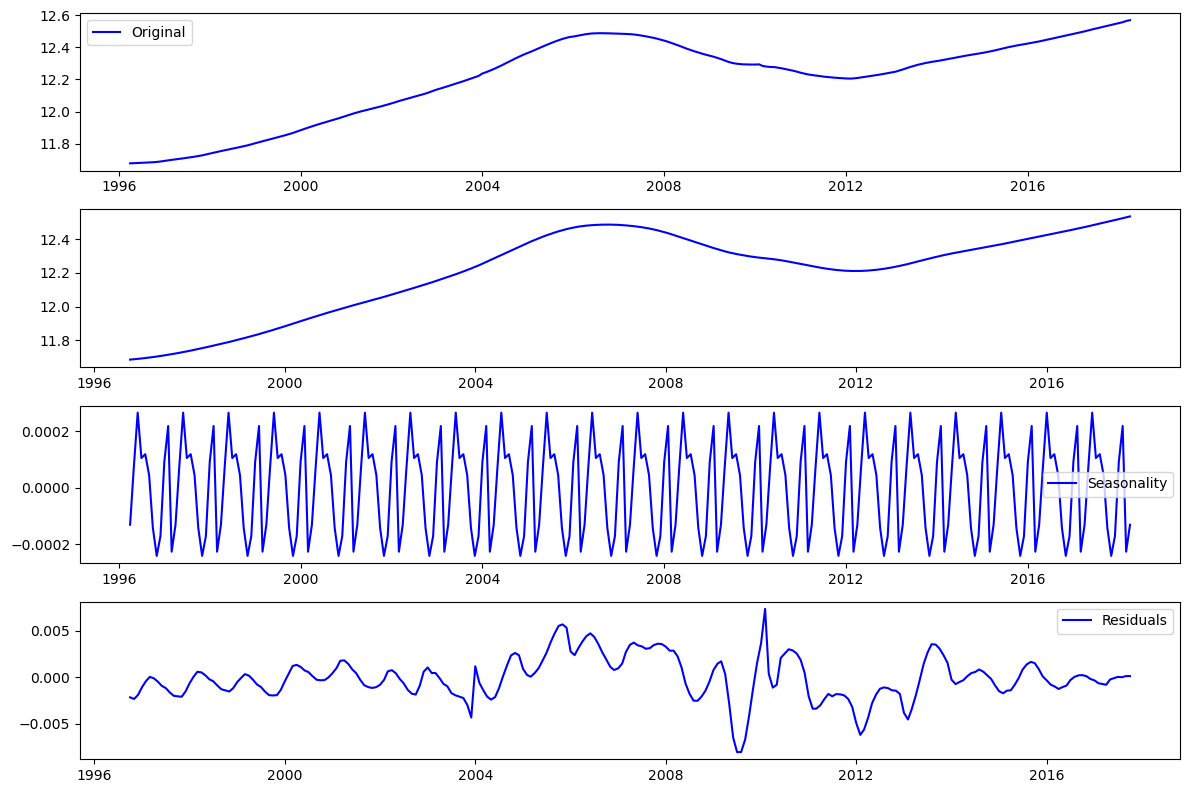

In [8]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(monthly_data))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(monthly_data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

This makes it easier to identify a changing mean or variation in our data. From the decomposition plot it clearly shows an upward trend in our series with seasonality and minimal variation.We will need to detrend our data because if seasonality and trend are part of the time series then there will be effects in the forecast value. As the pattern of the forecasted time series can be different from the older time series.

#### Detrending the Series

In [9]:
# Differencing to remove trends

data_diff = monthly_data.diff(periods=24).dropna()
data_diff.head(5)


Date
1998-04-01     9394.335394
1998-05-01     9917.679821
1998-06-01    10441.734022
1998-07-01    10964.776201
1998-08-01    11481.274197
Freq: MS, Name: value, dtype: float64

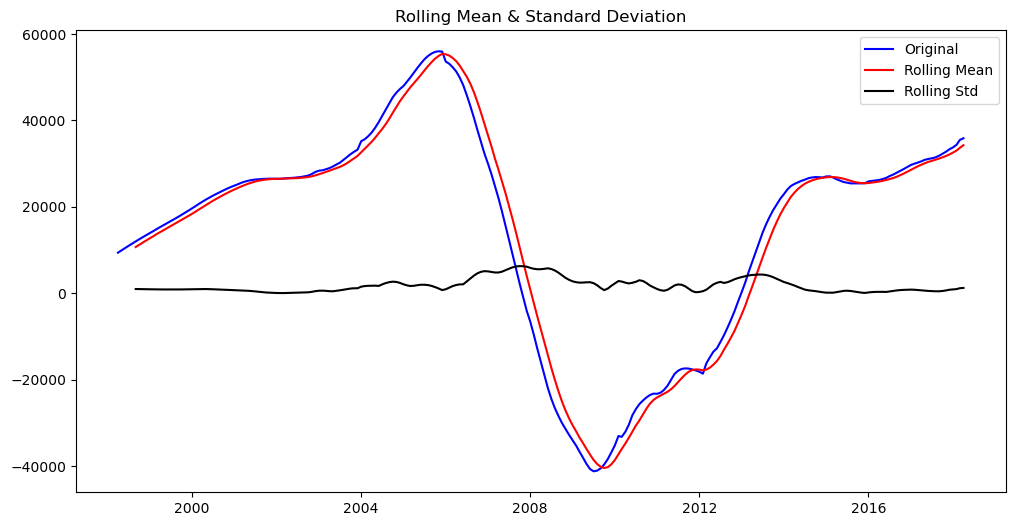

Results of Dickey-Fuller Test: 

Test Statistic                  -3.109067
p-value                          0.025889
#Lags Used                       2.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [10]:
# Rechecking stationarity

stationarity_check(data_diff)

The p-value is now below 0.05 therefore we reject the null hypothesis that the series is non-stationary.

#### Correlation of the Differenced Data

Plotting the ACF and PACF functions help determine the AR and MA components in the models we intend to build. These functions consider all the above components of a time series like the trend and the seasonality and find their correlations

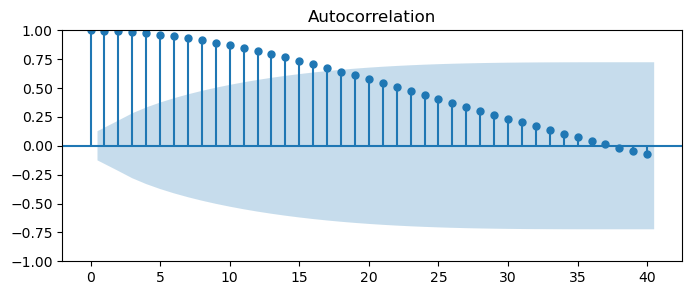

In [11]:
# Plot the ACF

from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(data_diff,ax=ax, lags= 40);

From the above lags between 1 and 17 are in statistically significant region meaning time periods within that span can affect present values

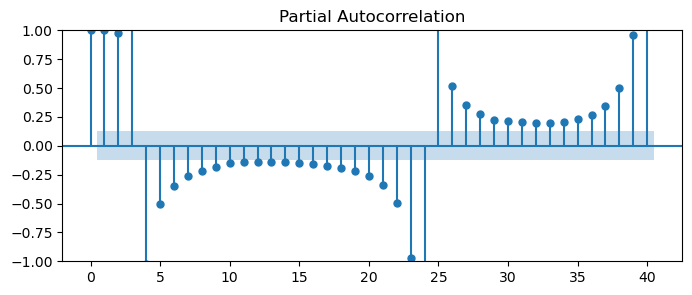

In [12]:
# Plot the PACF

from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(data_diff,ax=ax, lags=40);

From lags 1 to 4 the 

#### Time Series Modelling

The AIC(Akaike's Information Criterion) and BIC(Bayesian Information Criterion) will be determinants of the the model perfomances. 

AIC is a metric that helps in the evaluation of a model that takes the results of the maximum likelihood as well as the total number of parameters. The lower the AIC the better the model performance. 

The BIC is similar to AIC but differs in that it considers the number of rows in the dataset. The lower the BIC the better the model performance.

#### Baseline Model

We will construct an MA model as our baseline model then increase its complexity with more complex models.

In [13]:
# Fit an ARMA model
mod_ma = ARIMA(data_diff, order=(0,0,1))
res_ma = mod_ma.fit()

# Print out summary information on the fit
print(res_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2620.418
Date:                Wed, 30 Nov 2022   AIC                           5246.837
Time:                        03:35:48   BIC                           5257.291
Sample:                    04-01-1998   HQIC                          5251.049
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04   2058.572      7.210      0.000    1.08e+04    1.89e+04
ma.L1          1.0000      0.132      7.562      0.000       0.741       1.259
sigma2      1.652e+08    8.9e-07   1.86e+14      0.0

The huge nature of the cofficients are evident that our model is very unsafisfactory.This model has a high AIC of 5246.837 that justfies its unsatisfactory nature. Also, the BIC is large 5257.291 that affirms this conclusion.

#### AR Model

In [14]:
# Fit an AR model
mod_ar = ARIMA(data_diff, order=(1,0,0))
res_ar = mod_ar.fit()

# Print out summary information on the fit
print(res_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2073.427
Date:                Wed, 30 Nov 2022   AIC                           4152.854
Time:                        03:35:48   BIC                           4163.308
Sample:                    04-01-1998   HQIC                          4157.065
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04   3.22e+04      0.461      0.645   -4.82e+04    7.79e+04
ar.L1          0.9977      0.003    368.889      0.000       0.992       1.003
sigma2      1.704e+06   4073.492    418.312      0.0

This second model is an improvement of the first model. It has lower AIC and BIC values that stands at 4152.854, and 4163.308 respectively.

#### ARMA Model

In [15]:
# Fit an ARMA model
mod_arma = ARIMA(data_diff, order=(1,0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1966.920
Date:                Wed, 30 Nov 2022   AIC                           3941.840
Time:                        03:35:50   BIC                           3955.780
Sample:                    04-01-1998   HQIC                          3947.456
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04   3.39e+04      0.437      0.662   -5.17e+04    8.14e+04
ar.L1          0.9973      0.003    323.820      0.000       0.991       1.003
ma.L1          0.7497      0.038     19.599      0.0

The third model is an improvement of the first and second model. It has lower AIC and BIC values that stands at 3941.840, and 3955.780 respectively.

#### ARIMA Model

In [16]:
# Fit an ARIMA model

mod_arima = ARIMA(data_diff, order=(1,1,1))
res_arima = mod_arima.fit()

# Print out summary information on the fit
print(res_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1786.068
Date:                Wed, 30 Nov 2022   AIC                           3578.136
Time:                        03:35:51   BIC                           3588.578
Sample:                    04-01-1998   HQIC                          3582.343
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9388      0.010     98.014      0.000       0.920       0.958
ma.L1         -0.2384      0.042     -5.641      0.000      -0.321      -0.156
sigma2      1.487e+05   4248.325     34.996      0.0

Fantastic! Our AIC and BIC keep getting lower which means our model is performing better.

#### SARIMA Model

SARIMA is the ideal model to apply since it takes seasonality into account.

In [17]:
#using auto_arima- it does a random search for the best pdq,PDQS  
sarima_model = pm.auto_arima(monthly_data, 
                             m=12,
                             seasonal=True,
                             start_p=0,
                             start_q=0,
                             start_P=0,
                             start_Q=0,
                             max_order=6, 
                             test='adf',
                             error_action='warn',  
                             suppress_warnings=True,
                              stepwise=True,
                              trace=False)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1851.209
Date:                Wed, 30 Nov 2022   AIC                           3712.419
Time:                        03:39:01   BIC                           3730.317
Sample:                    04-01-1996   HQIC                          3719.610
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     97.0645    100.271      0.968      0.333     -99.462     293.591
ar.L1          1.9897      0.008    234.922      0.000       1.973       2.006
ar.L2         -0.9901      0.009   -114.892      0.000      -1.007      -0.973
ma.L1         -0.2281      0.028     -8.089      0.000      -0.283      -0.173
sigma2      6.483e+04      1.556   4.17e+04      0.000    6.48e+04    6.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             12641.35
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                            -2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.18e+19. Standard errors may be unstable.
"""

The SARIMA performed worse compared to the last model. This was unexpected hence we will hyperparameter tune the model to see whether we get better results.

In [18]:
# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0,2)

# Generate all different combinations of p, d , q and s
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [19]:
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(data_diff,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = model.fit()
            ans.append([comb, combs, output.aic])
           
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16551D+01    |proj g|=  1.27187D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.272D-07   1.166D+01
  F =   11.655128394192152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.07745D+01    |proj g|=  2.21977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     16      1     0     0   2.220D-05   1.077D+01
  F =   10.774515933686548     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04338D+01    |proj g|=  3.67351D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23618D+01    |proj g|=  6.96933D-02


 This problem is unconstrained.



At iterate    5    f=  9.66921D+00    |proj g|=  6.51111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     16      1     0     0   3.353D-05   9.669D+00
  F =   9.6692130170672925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04577D+01    |proj g|=  1.88493D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   1.870D-05   1.046D+01
  F =   10.457712647724343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50021D+01    |proj g|=  5.20539D-01


 This problem is unconstrained.



At iterate    5    f=  1.31632D+01    |proj g|=  7.96003D-01

At iterate   10    f=  1.17161D+01    |proj g|=  1.90250D+00

At iterate   15    f=  1.01559D+01    |proj g|=  3.68518D-02

At iterate   20    f=  1.01552D+01    |proj g|=  5.24819D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     34      1     0     0   3.746D-05   1.016D+01
  F =   10.155176473851212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19473D+01    |proj g|=  5.03789D-02


 This problem is unconstrained.



At iterate    5    f=  9.59282D+00    |proj g|=  2.52192D-01

At iterate   10    f=  9.52005D+00    |proj g|=  4.58559D-02

At iterate   15    f=  9.51824D+00    |proj g|=  2.92314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     35      1     0     0   2.923D-05   9.518D+00
  F =   9.5182435341233553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20893D+01    |proj g|=  4.21399D-01

At iterate    5    f=  1.12442D+01    |proj g|=  1.01141D-01

At iterate   10    f=  1.12429D+01    |proj g|=  9.89738D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     35      1     0     0   9.897D-05   1.124D+01
  F =   11.242946991519780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.13409D+01    |proj g|=  1.90752D-01

At iterate   10    f=  1.13380D+01    |proj g|=  2.11276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     31      1     0     0   1.782D-05   1.134D+01
  F =   11.337959574913654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04855D+01    |proj g|=  5.05373D-01


 This problem is unconstrained.



At iterate    5    f=  1.00461D+01    |proj g|=  4.53111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   4.636D-05   1.005D+01
  F =   10.046083698295510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29956D+01    |proj g|=  5.86900D-01


 This problem is unconstrained.



At iterate    5    f=  1.15671D+01    |proj g|=  6.00427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     22      1     0     0   7.556D-05   1.157D+01
  F =   11.566935015156167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14718D+01    |proj g|=  3.98572D-01

At iterate    5    f=  1.06826D+01    |proj g|=  1.73591D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     20      1     0     0   3.013D-05   1.068D+01
  F =   10.682419218871624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.27702D+01    |proj g|=  3.06956D+00

At iterate   10    f=  1.05812D+01    |proj g|=  3.26667D-02

At iterate   15    f=  1.05755D+01    |proj g|=  1.83615D-02

At iterate   20    f=  1.05714D+01    |proj g|=  4.37539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     44      1     0     0   3.108D-05   1.057D+01
  F =   10.571225543321960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.55519D+00    |proj g|=  1.19670D-02

At iterate   10    f=  9.55518D+00    |proj g|=  1.47479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     25      1     0     0   5.064D-05   9.555D+00
  F =   9.5551753674796949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29852D+01    |proj g|=  5.81639D-01


 This problem is unconstrained.



At iterate    5    f=  1.07997D+01    |proj g|=  8.51483D-01

At iterate   10    f=  1.02799D+01    |proj g|=  6.38802D-01

At iterate   15    f=  1.01721D+01    |proj g|=  5.24717D-02

At iterate   20    f=  1.01712D+01    |proj g|=  3.05755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     38      1     0     0   3.058D-05   1.017D+01
  F =   10.171244444045925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52362D+00    |proj g|=  5.85665D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.857D-06   8.524D+00
  F =   8.5236195647368316     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.8

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61153D+00    |proj g|=  1.19297D-01

At iterate    5    f=  7.55528D+00    |proj g|=  2.34156D-04

At iterate   10    f=  7.55526D+00    |proj g|=  5.41707D-03

At iterate   15    f=  7.55362D+00    |proj g|=  5.09554D-02

At iterate   20    f=  7.51563D+00    |proj g|=  6.33321D-02

At iterate   25    f=  7.51313D+00    |proj g|=  7.80886D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86646D+00    |proj g|=  1.64740D-01


 This problem is unconstrained.



At iterate    5    f=  7.78023D+00    |proj g|=  2.24103D-03

At iterate   10    f=  7.78020D+00    |proj g|=  5.55548D-03

At iterate   15    f=  7.77719D+00    |proj g|=  8.28265D-02

At iterate   20    f=  7.71742D+00    |proj g|=  8.06837D-02

At iterate   25    f=  7.69943D+00    |proj g|=  2.16975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     33      1     0     0   1.713D-07   7.699D+00
  F =   7.6994255725956400     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62269D+00    |proj g|=  6.75615D-02


 This problem is unconstrained.



At iterate    5    f=  7.52620D+00    |proj g|=  3.39788D-04

At iterate   10    f=  7.52619D+00    |proj g|=  3.68453D-03

At iterate   15    f=  7.52558D+00    |proj g|=  4.49338D-02

At iterate   20    f=  7.49837D+00    |proj g|=  2.19056D-01

At iterate   25    f=  7.47733D+00    |proj g|=  1.05389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   1.044D-06   7.477D+00
  F =   7.4773259848892799     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18595D+00    |proj g|=  2.64941D-02

At iterate    5    f=  8.18577D+00    |proj g|=  2.27908D-03

At iterate   10    f=  8.18539D+00    |proj g|=  3.77858D-02

At iterate   15    f=  8.12715D+00    |proj g|=  7.16331D-01

At iterate   20    f=  8.05028D+00    |proj g|=  5.09901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     25      1     0     0   3.903D-06   8.050D+00
  F =   8.0502791442321939     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70338D+00    |proj g|=  8.03015D-02

At iterate    5    f=  7.69974D+00    |proj g|=  9.86992D-04

At iterate   10    f=  7.69605D+00    |proj g|=  4.55564D-02

At iterate   15    f=  7.52167D+00    |proj g|=  4.16051D-01

At iterate   20    f=  7.37627D+00    |proj g|=  2.28454D-02

At iterate   25    f=  7.37605D+00    |proj g|=  9.15978D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.75434D+00    |proj g|=  1.35111D-03

At iterate   10    f=  7.75418D+00    |proj g|=  2.26551D-02

At iterate   15    f=  7.73437D+00    |proj g|=  3.09542D-01

At iterate   20    f=  7.68382D+00    |proj g|=  2.99377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     24      1     0     0   5.163D-07   7.684D+00
  F =   7.6838223119295632     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.33771D+00    |proj g|=  6.39153D-04

At iterate   10    f=  7.33753D+00    |proj g|=  5.78330D-03

At iterate   15    f=  7.30913D+00    |proj g|=  3.35662D-01

At iterate   20    f=  7.24969D+00    |proj g|=  7.02090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   1.771D-06   7.250D+00
  F =   7.2496863781714689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.80464D+00    |proj g|=  4.80650D-04

At iterate   10    f=  7.80324D+00    |proj g|=  3.29454D-02

At iterate   15    f=  7.67927D+00    |proj g|=  4.23340D-01

At iterate   20    f=  7.61409D+00    |proj g|=  3.80847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   4.278D-06   7.614D+00
  F =   7.6140921561466985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.69838D+00    |proj g|=  2.84074D-02

At iterate   10    f=  7.69768D+00    |proj g|=  5.47105D-04

At iterate   15    f=  7.69734D+00    |proj g|=  1.11479D-02

At iterate   20    f=  7.65960D+00    |proj g|=  1.47552D-01

At iterate   25    f=  7.38488D+00    |proj g|=  8.60828D-02

At iterate   30    f=  7.37119D+00    |proj g|=  4.59913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     42      1     0     0   1.790D-05   7.371D+00
  F =   7.3711920544960190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  7.41945D+00    |proj g|=  3.27366D-04

At iterate   10    f=  7.41943D+00    |proj g|=  8.16651D-03

At iterate   15    f=  7.41584D+00    |proj g|=  1.14504D-01

At iterate   20    f=  7.36131D+00    |proj g|=  9.49640D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   1.014D-05   7.360D+00
  F =   7.3596337513017662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.34676D+00    |proj g|=  8.42060D-02

At iterate   10    f=  7.31007D+00    |proj g|=  4.45939D-02

At iterate   15    f=  7.30905D+00    |proj g|=  7.72527D-04

At iterate   20    f=  7.30866D+00    |proj g|=  1.47451D-02

At iterate   25    f=  7.27497D+00    |proj g|=  1.29049D-01

At iterate   30    f=  7.19161D+00    |proj g|=  8.30845D-02

At iterate   35    f=  7.18488D+00    |proj g|=  2.49146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     46      1     0     0   7.687D-06   7.185D+00
  F =   7.1848765050765904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55659D+00    |proj g|=  2.49569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   2.496D-03   8.557D+00
  F =   8.5565941172915334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56924D+00    |proj g|=  1.21491D-01

At iterate    5    f=  8.84012D+00    |proj g|=  1.16346D+01

At iterate   10    f=  7.96494D+00    |proj g|=  3.98735D+00

At iterate   15    f=  7.89187D+00    |proj g|=  6.67379D-03

At iterate   20    f=  7.89186D+00    |proj g|=  1.39810D-02

At iterate   25    f=  7.89159D+00    |proj g|=  1.77482D-01

At iterate   30    f=  7.86073D+00    |proj g|=  2.57155D+00

At iterate   35    f=  7.76968D+00    |proj g|=  4.37430D-01

At iterate   40    f=  7.76905D+00    |proj g|=  2.76833D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07105D+00    |proj g|=  6.97450D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   6.973D-04   8.071D+00
  F =   8.0710496595666541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88542D+00    |proj g|=  1.34428D-01

At iterate    5    f=  7.60021D+00    |proj g|=  6.52967D-01

At iterate   10    f=  7.57951D+00    |proj g|=  4.26348D-04

At iterate   15    f=  7.57947D+00    |proj g|=  6.96342D-03

At iterate   20    f=  7.57660D+00    |proj g|=  6.16126D-02

At iterate   25    f=  7.55827D+00    |proj g|=  9.36848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.98641D+00    |proj g|=  1.45400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     11      1     0     0   2.183D-04   7.986D+00
  F =   7.9864120429814509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67694D+00    |proj g|=  1.97984D-01


 This problem is unconstrained.



At iterate    5    f=  9.48917D+00    |proj g|=  1.33448D-01

At iterate   10    f=  8.91137D+00    |proj g|=  9.61826D+00

At iterate   15    f=  7.88185D+00    |proj g|=  2.12780D-01

At iterate   20    f=  7.87793D+00    |proj g|=  5.22081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   4.091D-04   7.878D+00
  F =   7.8779335026076938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.65509D+00    |proj g|=  4.40946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.440D-05   7.655D+00
  F =   7.6550934460264202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80865D+00    |proj g|=  1.44266D-01


 This problem is unconstrained.



At iterate    5    f=  7.64282D+00    |proj g|=  3.36255D+00

At iterate   10    f=  7.54029D+00    |proj g|=  2.19734D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     29      1     0     0   2.223D-04   7.540D+00
  F =   7.5398395120158712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21891D+00    |proj g|=  2.46436D-02

At iterate    5    f=  8.21873D+00    |proj g|=  4.42506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   4.425D-04   8.219D+00
  F =   8.2187288043317857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.


  ys=-1.563E+00  -gs= 7.800E-01 BFGS update SKIPPED

At iterate    5    f=  7.75781D+00    |proj g|=  2.52428D-01

At iterate   10    f=  7.73299D+00    |proj g|=  9.27454D-03

At iterate   15    f=  7.73297D+00    |proj g|=  5.72827D-03

At iterate   20    f=  7.73285D+00    |proj g|=  9.15217D-02

At iterate   25    f=  7.71762D+00    |proj g|=  1.11087D+00

At iterate   30    f=  7.51137D+00    |proj g|=  1.77091D+00

At iterate   35    f=  7.40821D+00    |proj g|=  1.21963D-01

At iterate   40    f=  7.40791D+00    |proj g|=  7.78146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     56      1     1

 This problem is unconstrained.



At iterate    5    f=  7.79025D+00    |proj g|=  3.62098D-04

At iterate   10    f=  7.79022D+00    |proj g|=  8.61407D-03

At iterate   15    f=  7.78845D+00    |proj g|=  6.71945D-02

At iterate   20    f=  7.72346D+00    |proj g|=  2.04230D-01

At iterate   25    f=  7.71853D+00    |proj g|=  2.28245D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   2.351D-06   7.719D+00
  F =   7.7185286217121778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.44500D+00    |proj g|=  2.38709D+00

At iterate   10    f=  7.37271D+00    |proj g|=  8.86572D-02

At iterate   15    f=  7.37255D+00    |proj g|=  3.52901D-04

At iterate   20    f=  7.37249D+00    |proj g|=  2.40078D-02

At iterate   25    f=  7.36542D+00    |proj g|=  4.06283D-01

At iterate   30    f=  7.29334D+00    |proj g|=  9.31418D-02

At iterate   35    f=  7.29061D+00    |proj g|=  1.96579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     54      1     0     0   5.690D-05   7.291D+00
  F =   7.2906005157596780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86080D+00    |proj g|=  2.67535D-01

At iterate    5    f=  7.80657D+00    |proj g|=  1.13521D-01

At iterate   10    f=  7.80610D+00    |proj g|=  2.26063D-03

At iterate   15    f=  7.80580D+00    |proj g|=  1.98002D-01

At iterate   20    f=  7.77514D+00    |proj g|=  2.38547D+00

At iterate   25    f=  7.62950D+00    |proj g|=  1.61159D-01

At iterate   30    f=  7.61425D+00    |proj g|=  2.25217D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     73      2     0     0   2.605D-04   7.614D+00
  F =   7.6142421303839773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61792D+00    |proj g|=  2.06869D-01

At iterate    5    f=  9.25532D+00    |proj g|=  2.01858D+00

At iterate   10    f=  7.94998D+00    |proj g|=  2.14748D+00

At iterate   15    f=  7.73898D+00    |proj g|=  6.11401D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  7.41892D+00    |proj g|=  2.78460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   3.284D-04   7.419D+00
  F =   7.4188980811921743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73153D+00    |proj g|=  1.44707D-01


 This problem is unconstrained.



At iterate    5    f=  7.57883D+00    |proj g|=  3.01285D+00

At iterate   10    f=  7.36386D+00    |proj g|=  2.01514D-01

At iterate   15    f=  7.34337D+00    |proj g|=  2.47378D-02

At iterate   20    f=  7.34333D+00    |proj g|=  3.49030D-03

At iterate   25    f=  7.34271D+00    |proj g|=  7.65388D-02

At iterate   30    f=  7.28930D+00    |proj g|=  5.68378D-01

At iterate   35    f=  7.22683D+00    |proj g|=  1.39921D-01

At iterate   40    f=  7.21711D+00    |proj g|=  2.05347D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     59      1     0     0   7.897D-06   7.217D+00
  F =   7.21711150698

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   5.288D-05   7.350D+00
  F =   7.3500983461637937     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98211D+00    |proj g|=  2.33203D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/user/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  6.97560D+00    |proj g|=  2.23224D-04

At iterate   10    f=  6.97553D+00    |proj g|=  7.26148D-03

At iterate   15    f=  6.97377D+00    |proj g|=  2.74714D-02

At iterate   20    f=  6.97222D+00    |proj g|=  1.58728D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   1.587D-05   6.972D+00
  F =   6.9722211347927443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   2.282D-05   7.295D+00
  F =   7.2953586548156979     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96954D+00    |proj g|=  1.58513D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.77347D+00    |proj g|=  1.71662D-02

At iterate   10    f=  6.77343D+00    |proj g|=  6.16667D-03

At iterate   15    f=  6.77241D+00    |proj g|=  9.42667D-02

At iterate   20    f=  6.72898D+00    |proj g|=  1.73795D-01

At iterate   25    f=  6.72133D+00    |proj g|=  7.76805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     33      1     0     0   7.915D-06   6.721D+00
  F =   6.7213273798883479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.00477D+00    |proj g|=  3.11034D-04

At iterate   10    f=  7.00476D+00    |proj g|=  3.76762D-03

At iterate   15    f=  7.00429D+00    |proj g|=  1.28799D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   2.774D-06   7.004D+00
  F =   7.0041936523578734     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18548D+00    |proj g|=  6.07087D-01


 This problem is unconstrained.



At iterate    5    f=  6.94438D+00    |proj g|=  3.59158D-01

At iterate   10    f=  6.92633D+00    |proj g|=  1.29231D-03

At iterate   15    f=  6.92632D+00    |proj g|=  3.18652D-03

At iterate   20    f=  6.92533D+00    |proj g|=  4.78131D-02

At iterate   25    f=  6.91210D+00    |proj g|=  1.49302D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   5.969D-06   6.912D+00
  F =   6.9119890867182514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.91916D+00    |proj g|=  3.38249D-05

At iterate   10    f=  6.91915D+00    |proj g|=  7.95076D-03

At iterate   15    f=  6.91906D+00    |proj g|=  1.27215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   1.351D-06   6.919D+00
  F =   6.9190586227668485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98819D+00    |proj g|=  3.49956D-01


 This problem is unconstrained.



At iterate    5    f=  6.82376D+00    |proj g|=  5.89825D-01

At iterate   10    f=  6.77108D+00    |proj g|=  5.36005D-03

At iterate   15    f=  6.77108D+00    |proj g|=  3.27920D-03

At iterate   20    f=  6.77071D+00    |proj g|=  4.79359D-02

At iterate   25    f=  6.73921D+00    |proj g|=  4.01594D-01

At iterate   30    f=  6.71878D+00    |proj g|=  4.60120D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     38      1     0     0   2.293D-06   6.719D+00
  F =   6.7187698132035329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92331D+00    |proj g|=  2.17970D-01

At iterate    5    f=  6.91849D+00    |proj g|=  1.43512D-02

At iterate   10    f=  6.91844D+00    |proj g|=  2.84673D-04

At iterate   15    f=  6.91839D+00    |proj g|=  8.50423D-03

At iterate   20    f=  6.91700D+00    |proj g|=  4.87780D-02

At iterate   25    f=  6.91331D+00    |proj g|=  2.65564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91371D+00    |proj g|=  1.59662D-01


 This problem is unconstrained.



At iterate    5    f=  6.74975D+00    |proj g|=  7.40795D-01

At iterate   10    f=  6.71953D+00    |proj g|=  6.78781D-03

At iterate   15    f=  6.71952D+00    |proj g|=  5.26573D-03

At iterate   20    f=  6.71919D+00    |proj g|=  7.20772D-02

At iterate   25    f=  6.69582D+00    |proj g|=  4.54520D-01

At iterate   30    f=  6.66764D+00    |proj g|=  2.08336D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     42      1     0     0   3.198D-06   6.668D+00
  F =   6.6675949223344828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.98233D+00    |proj g|=  8.66889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   8.115D-05   6.982D+00
  F =   6.9822988431125843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11948D+00    |proj g|=  5.81210D-01


 This problem is unconstrained.



At iterate    5    f=  6.94479D+00    |proj g|=  6.22814D-02

At iterate   10    f=  6.87136D+00    |proj g|=  1.16395D-02

At iterate   15    f=  6.87130D+00    |proj g|=  1.19416D-03

At iterate   20    f=  6.87125D+00    |proj g|=  2.40165D-02

At iterate   25    f=  6.86643D+00    |proj g|=  2.27932D-01

At iterate   30    f=  6.85353D+00    |proj g|=  1.19168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   1.982D-06   6.853D+00
  F =   6.8534338443950604     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.89359D+00    |proj g|=  7.12516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   9.995D-06   6.894D+00
  F =   6.8935916502472674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93173D+00    |proj g|=  3.45564D-01


 This problem is unconstrained.



At iterate    5    f=  6.79158D+00    |proj g|=  7.87748D-01

At iterate   10    f=  6.71738D+00    |proj g|=  9.99868D-02

At iterate   15    f=  6.71616D+00    |proj g|=  6.34902D-04

At iterate   20    f=  6.71608D+00    |proj g|=  1.44084D-02

At iterate   25    f=  6.71067D+00    |proj g|=  1.27978D-01

At iterate   30    f=  6.66358D+00    |proj g|=  8.51972D-03

At iterate   35    f=  6.66352D+00    |proj g|=  9.40847D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     39      1     0     0   9.408D-07   6.664D+00
  F =   6.6635192391539935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [20]:
param_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
param_df

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",5619.771886
1,"(0, 0, 0)","(0, 0, 1, 12)",5197.316680
2,"(0, 0, 0)","(0, 1, 0, 12)",5031.069847
3,"(0, 0, 0)","(0, 1, 1, 12)",4664.560674
4,"(0, 0, 0)","(1, 0, 0, 12)",5044.617496
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",3221.780753
60,"(1, 1, 1)","(1, 0, 0, 12)",3373.468042
61,"(1, 1, 1)","(1, 0, 1, 12)",3313.355113
62,"(1, 1, 1)","(1, 1, 0, 12)",3330.711175


In [22]:
param_df.loc[param_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic       3221.780753
Name: 59, dtype: object

In [23]:
sarima_mod2 = sm.tsa.statespace.SARIMAX(data_diff,
                                order=(3, 1, 3),
                                seasonal_order=(3, 1, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sar_results = sarima_mod2 .fit()

print(sar_results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97521D+00    |proj g|=  3.80674D-01


 This problem is unconstrained.



At iterate    5    f=  5.87170D+00    |proj g|=  5.19440D-01

At iterate   10    f=  5.84837D+00    |proj g|=  3.37662D-01

At iterate   15    f=  5.84106D+00    |proj g|=  2.34818D-02

At iterate   20    f=  5.83763D+00    |proj g|=  5.21616D-01

At iterate   25    f=  5.83594D+00    |proj g|=  3.08631D-02

At iterate   30    f=  5.83468D+00    |proj g|=  1.49511D-02

At iterate   35    f=  5.83459D+00    |proj g|=  4.26111D-03

At iterate   40    f=  5.83454D+00    |proj g|=  2.08033D-02

At iterate   45    f=  5.83449D+00    |proj g|=  2.29604D-02


/home/user/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.83445D+00    |proj g|=  2.30681D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.307D-02   5.834D+00
  F =   5.8344513651787624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  241
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -1406.103
Date:                            Wed, 30 Nov 2022   AIC                           2838.2

After fitting all models,the tuned SARIMA model had the least AIC (2838) making it the best model.

#### Model Evaluation and Forecasting

#### Non-Dynamic

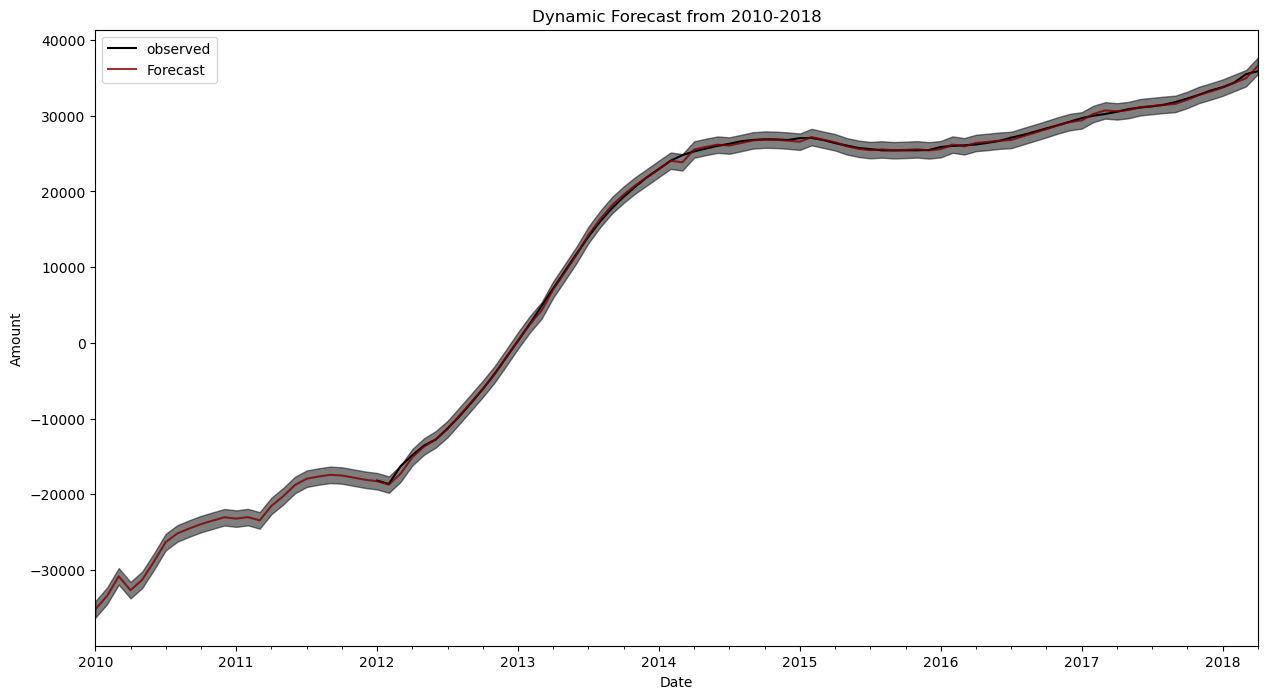

In [28]:
pred = sar_results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)

pred_ci = pred.conf_int() # this gives us the confidence interval for our forecasts

plt.figure(figsize = (15,8))
ax = data_diff['2012':].plot(label='observed',color='black')

pred.predicted_mean.plot(ax=ax, label='Forecast', color='maroon',alpha=0.8)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.5)

ax.set_title('Dynamic Forecast from 2010-2018')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [37]:
# evaluation

y_ndynamic = pred.predicted_mean
y_actual = data_diff['2010-01-01':]

mean_absolute_percentage_error(y_actual, y_ndynamic)

0.012820724013374633

#### Dynamic 

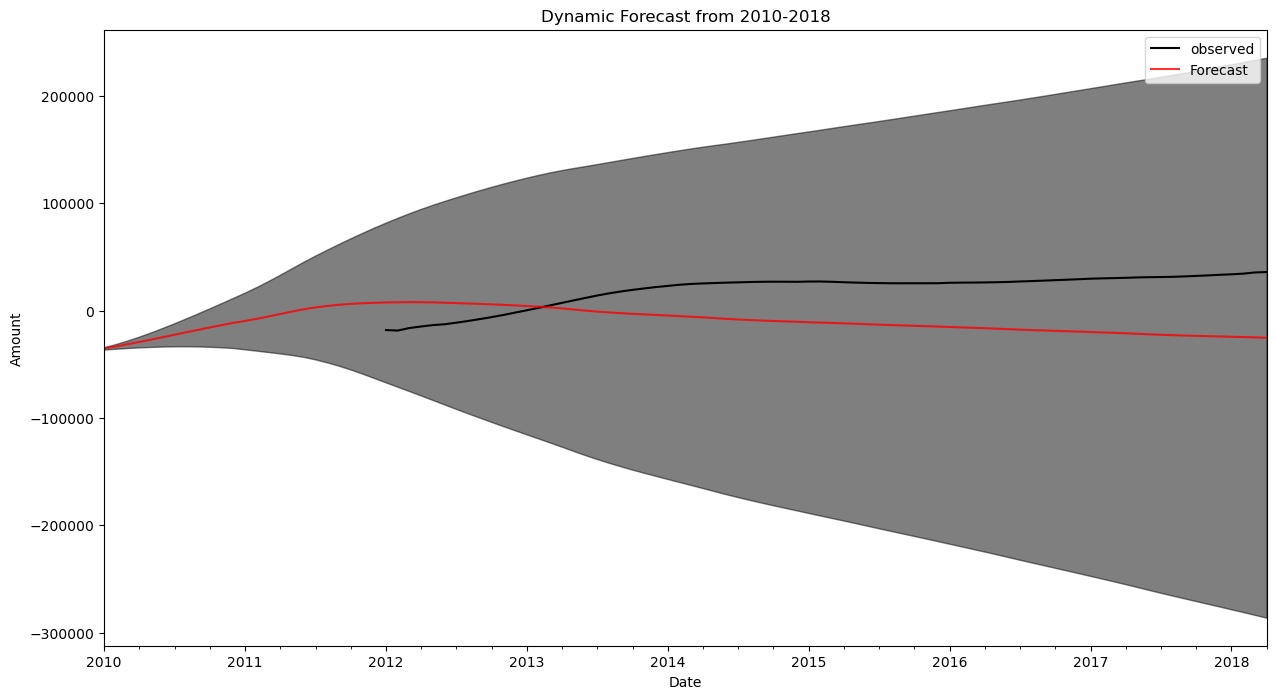

In [38]:
# forecasting

pred_dynamic = sar_results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

# Visualizing forecasted values

plt.figure(figsize = (15,8))
ax = data_diff['2012':].plot(label='observed',color='black')
pred_dynamic.predicted_mean.plot(ax=ax, label='Forecast', color='red',alpha=0.8)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.5)

ax.set_title('Dynamic Forecast from 2010-2018')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()


In [39]:
# Evaluation
y_dynamic = pred_dynamic .predicted_mean
y_dactual = data_diff['2010-01-01':]
mean_absolute_percentage_error(y_dynamic, y_dactual)

4.988837531804594

#### Future Prediction

In [50]:
#prediction 5 years into the future

pred_fut = sar_results.get_forecast(steps= 72)

# Get confidence intervals of forecasts
pred_ci = pred_fut.conf_int()



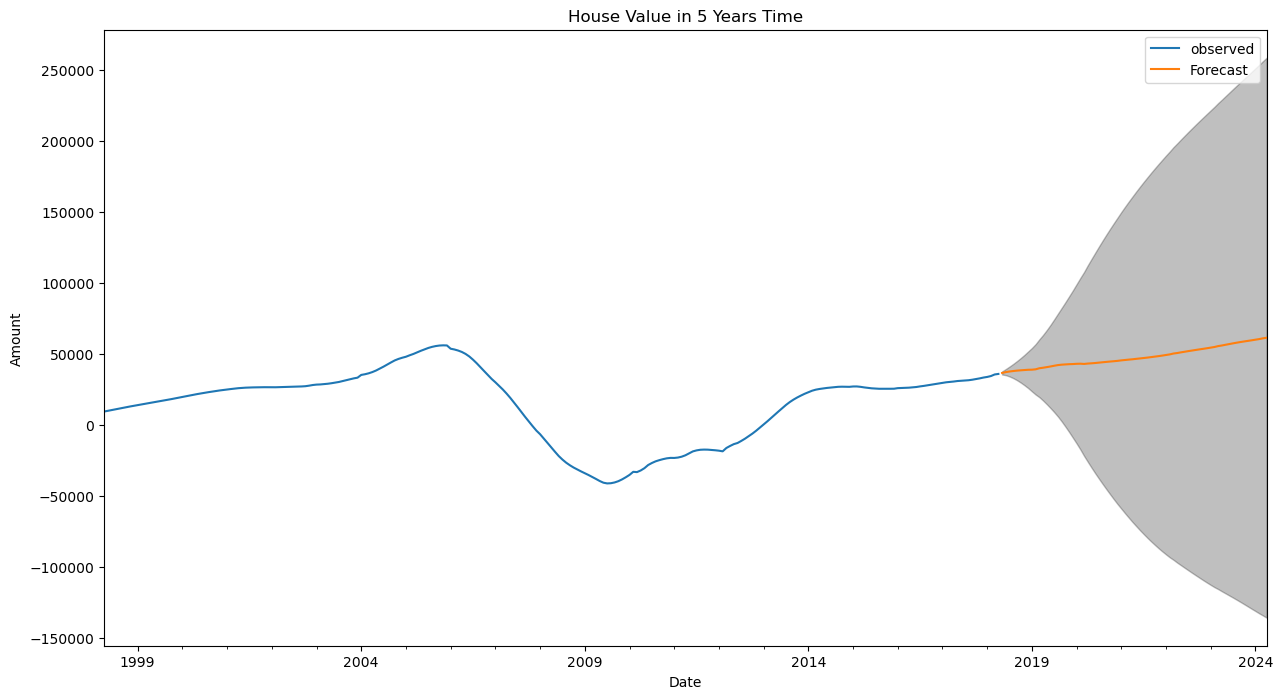

In [51]:
# Forecasting

ax =data_diff.plot(label='observed', figsize=(15, 8))
pred_fut .predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('House Value in 5 Years Time')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')

plt.legend()
plt.show()

In [48]:
# Long Term Investment

#prediction 20 years into the future

pred_fut_20 = sar_results.get_forecast(steps= 240)

# Get confidence intervals of forecasts
pred_ci = pred_fut_20.conf_int()


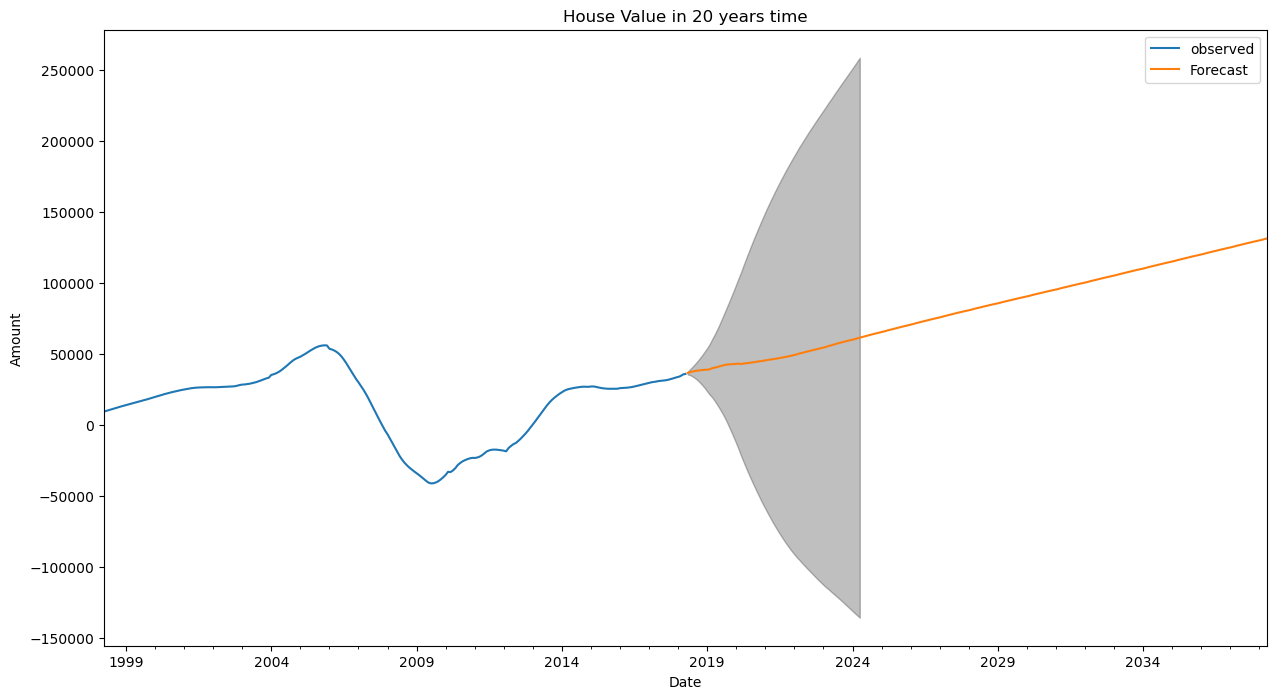

In [52]:
#Visualizing house values in 20 years
ax =data_diff.plot(label='observed', figsize=(15, 8))
pred_fut_20 .predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('House Value in 20 years time')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')

plt.legend()
plt.show()